<a href="https://colab.research.google.com/github/SizhuangHe/FL-REU/blob/main/FL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [1]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary

# Check assigned GPU
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
#   print('and then re-execute this cell.')
# else:
#   print(gpu_info)

# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Some Hyperparameters

In [2]:
input_size = 13
num_hidden_neuron = 5
num_classes = 1
output_size = num_classes

# Models

In [3]:
class IRIS_NN(nn.Module):
  def __init__(self, input_size, num_hidden_neurons, output_size):
    super(IRIS_NN, self).__init__()

    self.l1 = nn.Linear(input_size, num_hidden_neurons)
    self.l2 = nn.Linear(num_hidden_neurons, num_hidden_neurons)
    self.l3 = nn.Linear(num_hidden_neurons, output_size)

  def forward(self, x):
    x = torch.flatten(x,1)
    x = F.relu(self.l1(x))
    x = F.relu(self.l2(x))
    out = self.l3(x)
    return out

# Load DataSet

## Prepare the Data

### Dataset setup

In [4]:
# df = pd.read_csv("Iris.csv")

# le=LabelEncoder()
# df['Species']=le.fit_transform(df['Species'])

# label=df['Species'].values

# scaler=StandardScaler()
# df = df.drop('Species',axis=1)
# df = df.drop('Id', axis=1)
# scaled_df=scaler.fit_transform(df)

# feature=scaled_df.astype(np.float32)

In [5]:
class IrisData(Dataset):
  def __init__(self, feature_train, label_train):
    self.feature = feature_train
    self.label = label_train

  def __len__(self):
    return len(self.label) 

  def __getitem__(self, idx):
    sample = self.feature[idx]
    return sample, self.label[idx]   

### Transform (Add Gaussian Noise)

In [6]:
def add_gaussian_noise(dataset, client_dict, client, mean, std):
  #loader = DataLoader(CustomDataset(dataset, client_dict[client]), batch_size=len(client_dict[client]), shuffle=True)
  
  for data, label in CustomDataset(dataset, client_dict[client]):
    data += (torch.randn(len(data)) * std + mean).numpy()

In [7]:
# class AddGaussianNoise(object):
#     def __init__(self, mean=0., std=1.):
#         self.std = std
#         self.mean = mean
        
#     def __call__(self, sample):
#       sample += (torch.randn(sample.size) * self.std + self.mean).numpy()
#       return sample
    
#     def __repr__(self):
#         return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


### Other built-in dataset

#### MNIST

In [8]:
# transforms_mnist = transforms.Compose([
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.1307,), (0.3081,))
#                                        ])

# dataset_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=transforms_mnist)
# dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=transforms_mnist)

#### sklearn Boston dataset (Regression)

In [9]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
feature = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]]).astype(np.float32)
label = raw_df.values[1::2, 2].astype(np.float32)

scaler=StandardScaler()
feature = scaler.fit_transform(feature)

### Data preparation

In [10]:
feature_train,feature_test,label_train, label_test=train_test_split(feature, label,test_size=0.20,random_state=42)

In [11]:
dataset_train = IrisData(feature_train, label_train) # only the __init__ function is called here
dataset_test = IrisData(feature_test, label_test)

In [12]:
classes_test = [i for i in range(num_classes)]

# Partition the Data

In [13]:
def iid_partition(dataset, clients, report_iid_metric=False):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  if report_iid_metric == True:
    report_client_mean_variance(client_dict)
    
  return client_dict

In [14]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client, report_iid_metric=False):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Randomly assign each client with  shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """

  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  client_dict_out = {}
  idxs = np.arange(len(dataset))
  #print(f"idxs: {idxs}")
  
  data_labels = dataset.label
  #data_labels = dataset.targets.numpy()
  #print(f"data_labels: {data_labels}")

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  #print(f"label_idx: {label_idxs}")
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  #print(f"label_idx new: {label_idxs}")
  idxs = label_idxs[0,:].astype(int)
  #print(f"idxs new: {idxs}")

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    #print(f"rand_set: {rand_set}")
    shard_idxs = list(set(shard_idxs) - rand_set)
    #print(f"shard_idxs: {shard_idxs}")

    for rand in rand_set:
      #print(f"to append: {idxs[rand*shards_size:(rand+1)*shards_size]}")
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]))

      set_i = set(client_dict[i])
      client_dict_out[i] = set_i

  if report_iid_metric == True:
    report_client_mean_variance(client_dict_out)  
  return client_dict_out

In [15]:
def client_dict_train_val_split(client_dict_in, validation_ratio):
  """
  Split each client data randomly to two parts: training data and validation data

  param:
    - client_dict_in (python dictionary): the client dictionary
    - validation_ratio (double): the proportion of client data to be spitted into validation data

  returns:
    - dictionary of indices for each client's training and validation data  
  """
  client_dict_out = {}


  for client in client_dict_in:
    num_total_data = len(client_dict_in[client])
    num_val_data = int(num_total_data * validation_ratio)
    val_set = set(np.random.choice(np.array(list(client_dict_in[client])), num_val_data, replace=False))
    train_set = client_dict_in[client] - val_set
    client_dict_out[client]={}
    client_dict_out[client]["train"] = train_set
    client_dict_out[client]["validation"] = val_set
    
  return client_dict_out  

In [16]:
# Not sure if to account client dataset size
def report_client_mean_variance(client_dict):
  """
  This function returns the mean of each client's local training set
  Can use this to roughly see how iid the dictionary is
  """
  mean = []

  for client in client_dict:
    loader =  DataLoader(CustomDataset(dataset_train, client_dict[client]), batch_size=len(client_dict[client]), shuffle=True)
    ld = iter(loader).next()
    data, label = ld
    for i in range(len(client_dict[client])):
      mean.append(torch.mean(label).item())

  #print(mean)  
  print("Variance of mean client data: ", np.var(mean))
  print("Note: a small value is expected for i.i.d partition.")

# Client Training


In [17]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label

class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, client_set):
    self.train_loader = DataLoader(CustomDataset(dataset, client_set["train"]), batch_size=batchSize, shuffle=True)
    self.dataset = dataset
    self.idx_set = client_set["validation"]
    self.learning_rate = learning_rate
    self.epochs = epochs

  def train(self, model):

    #criterion = nn.CrossEntropyLoss()
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)
    # optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

    e_loss = []

    

    for epoch in range(1, self.epochs+1):

      train_loss = 0.0

      model.train()
      for data, labels in self.train_loader:

        if torch.cuda.is_available():
          data, labels = data.cuda(), labels.cuda()

        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)
        # calculate the loss
        length = len(labels)
        labels = labels.view((length,1)) # to make dimensions right
        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)

      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    # validation
    model.eval()
    val_loss = local_validate(model=model, dataset=self.dataset, idx_set=self.idx_set, criterion=criterion)

    return model.state_dict(), total_loss, val_loss

# Server Training

## Weights Functions

In [18]:
def size_of_clients(client_dict, active_client):
  """
  This function returns the sizes of each clients.

  Params:
    - client_dict (dictionary): a dictionary of clients
    - active_clients (array): each element is an active client, used as a key to search in client_dict

  Returns:
    - client_sizes (array): each element corresponds to the size of local dataset of clients in active_client, Note: the order should match with active_clients  
  """

  client_sizes = []
  for ac in range(len(active_client)):
    size = len(client_dict[active_client[ac]]["train"])
    client_sizes.append(size)

  return client_sizes  

### calc_weights
Note only run one of the following at a time

In [19]:
def calc_weights(client_sizes, val_losses):
  """
  This function determines the weights of each local model when the server is aggregating the models.

  Params:
    - client_sizes (array): an array of sizes of each client's local dataset
    - val_losses (array): an array of validation losses of each client's local model

  Returns:
    - weights_of_models (array): an array of computed weights of each cient model 
  """
  weights_of_models = []

  for i in range(len(client_sizes)):
    weights_of_models.append(client_sizes[i] / val_losses[i])

  total_weights = np.sum(weights_of_models)
  weights_of_models = weights_of_models / total_weights 
  return weights_of_models

In [20]:
# def calc_weights(client_sizes, val_losses):
#   weights_of_models = []

#   for i in range(len(client_sizes)):
#     weights_of_models.append(client_sizes[i] / np.exp(val_losses[i]))

#   total_weights = np.sum(weights_of_models)
#   weights_of_models = weights_of_models / total_weights 
#   return weights_of_models

In [21]:
# def calc_weights(client_sizes, val_losses):
#   weights_of_models = []

#   for i in range(len(client_sizes)):
#     weights_of_models.append(client_sizes[i] + 1/val_losses[i])

#   total_weights = np.sum(weights_of_models)
#   weights_of_models = weights_of_models / total_weights 
#   return weights_of_models

## Training

In [22]:
def training(model, rounds, batch_size, num_classes,lr, ds, data_dict, C, K, E, plt_title, plt_color, do_validation=False):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:           PyTorch model to train
    - rounds:          Number of communication rounds for the client update
    - batch_size:      Batch size for client update training
    - lr:              Learning rate used for client update training
    - ds:              Dataset used for training
    - data_dict:       Type of data partition used for training (IID or non-IID)
    - C:               Fraction of clients randomly chosen to perform computation on each round
    - K:               Total number of clients
    - E:               Number of training passes each client makes over its local dataset per round
    - tb_writer_name:  Directory name to save the tensorboard logs
  Returns:
    - model:           Trained model on the server
  """

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss = []
  
  
  # measure time
  start = time.time()

  for curr_round in range(1, rounds+1):
    w, local_loss, val_loss = [], [], []

    m = max(int(C*K), 1)
    
    S_t = np.random.choice(range(K), m, replace=False) # S_t is the array of clients to train on
    
    for k in S_t:
      local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=E, client_set=data_dict[k])
      weights, loss, local_val_loss = local_update.train(model=copy.deepcopy(model))

      #print(f"-> validate loss on client {k}: {local_val_loss}, -> training loss on client {k}: {loss}")
      val_loss.append(local_val_loss)

      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))
      # val_loss.append()

    # updating the global weights
    client_sizes = size_of_clients(data_dict, S_t)
    weights_of_models = calc_weights(client_sizes=client_sizes, val_losses=val_loss)

    # print(len(val_loss))
    # print(len(client_sizes))
    # print(len(weights_of_models))
    # print(len(w))

    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      weights_avg[k] = torch.mul(weights_avg[k], weights_of_models[0]) 
      for i in range(1, len(w)): 
        # index i here corresponds to each local model and index k here corresponds to each model weight 
        #print(i)
        #print(f"w[i][k]: {w[i][]k}, weights")
        weights_avg[k] += w[i][k] * weights_of_models[i]
      #weights_avg[k] = torch.div(weights_avg[k], len(w)) # take into account each client's number of data

    global_weights = weights_avg

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss) # didn't take into accound client data size
    train_loss.append(loss_avg)

    print("----------------------------Round Summary--------------------------------")
    print(f"---> Round: {curr_round}, Average training loss: {loss_avg}")
    print(f"---> Active Clients: {S_t}")
    print(f"---> Client Training Set Sizes: {client_sizes}")
    print(f"---> Validation losses: {val_loss}")
    print(f"---> Weights of Local Models: {weights_of_models}")
    print("-------------------------------------------------------------------------")

    

  end = time.time()

  fig_train, ax_train = plt.subplots()
  x_axis_train = np.arange(1, rounds+1)
  y_axis_train = np.array(train_loss)
  ax_train.plot(x_axis_train, y_axis_train, 'tab:'+plt_color)

  ax_train.set(xlabel='Number of Rounds', ylabel='Train Loss',
       title=plt_title)
  ax_train.grid()
  fig_train.savefig(plt_title+'.jpg', format='jpg')

  # fig_val, ax_val = plt.subplots()
  # x_axis_val = np.arange(1, rounds+1)
  # y_axis_val = np.array(val_loss)
  # ax_val.plot(x_axis_val, y_axis_val, 'tab:'+plt_color)

  # ax_val.set(xlabel='Number of Rounds', ylabel='Train Loss',
  #      title=plt_title)
  # ax_val.grid()
  # fig_val.savefig(plt_title+'.jpg', format='jpg')

  print("Training Done!")
  print("Total time taken to Train: {}".format(end-start))
  
  return model

# Validation

In [23]:
def local_validate(model, dataset, idx_set, criterion):
  """
  This function will do a validation of the model.

  Param:
    - model (torch.nn): the already trained Pytorch model to validate
    - dataset (torch.utils.Dataset): the dataset to load data from
    - idx_set (set): a set of integers, corresponding to the index of data to validate on
    - criterion: the loss function to use

  Returns:
    - val_loss (float): the loss of the model on this validation set  
  """

  val_loss = 0.0
  val_loader = DataLoader(CustomDataset(dataset, idx_set), batch_size=len(idx_set), shuffle=True)

  for data, labels in val_loader:
    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    length = len(labels)
    labels = labels.view((length,1)) # to make dimensions right
    loss = criterion(output, labels)
    
    val_loss += loss.item()*data.size(0)  

  val_loss = val_loss/len(val_loader.dataset)
  
  return val_loss

In [24]:
def gobal_validate(model, dataset, val_idx, criterion,num_classes, classes, report_accuracy):
  batch_size = len(val_idx)
  val_loader = DataLoader(CustomDataset(dataset, val_idx), batch_size=len(val_idx), shuffle=True)
  return test(model, dataset, batch_size, criterion, num_classes, classes, val_loader, "Validation", report_accuracy=report_accuracy)

# Test

In [25]:
def test(model, dataset, bs, criterion, num_classes, classes, loader, mode, report_accuracy):
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  for data, labels in loader:

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    length = len(labels)
    labels = labels.view((length,1)) # to make dimensions right
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    if report_accuracy == True:
      _, pred = torch.max(output, 1)
      correct_tensor = pred.eq(labels.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
      #print(f"data len: {len(data)}")
      #test accuracy for each object class
      for i in range(len(data)):
        label = labels.data[i]
        correct_class[label] += correct[i].item()
        total_class[label] += 1
        #print(f"i: {i}, label: {label}")

   
    
  # avg test loss
  test_loss = test_loss/len(loader.dataset)
  
  print(mode, "Loss: {:.6f}\n".format(test_loss))

  if report_accuracy == True:
    # print test accuracy
    for i in range(num_classes):
      if total_class[i]>0:
        print(mode, 'Accuracy of %5s: %2d%% (%2d/%2d)' % 
            (classes[i], 100 * correct_class[i] / total_class[i],
            np.sum(correct_class[i]), np.sum(total_class[i]))) 

      else:
        print(mode, 'Accuracy of %5s: N/A (no '% (classes[i]), mode, ' examples)' )
      
    print('\nFinal ', mode, ' Accuracy: {:.3f} ({}/{})\n'.format(
        100. * np.sum(correct_class) / np.sum(total_class),
        np.sum(correct_class), np.sum(total_class)))

  return test_loss

In [26]:
def testing(model, dataset, bs, criterion, num_classes, classes, report_accuracy):
  test_loader = DataLoader(dataset, batch_size=bs)
  
  model.eval()
  test(model, dataset, bs, criterion, num_classes, classes, test_loader, "Test", report_accuracy=report_accuracy)

# IID Case

## Training

In [27]:
# number of training rounds
rounds = 150
# client fraction
C = 1
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 10
# batch size
batch_size = 10
# learning Rate
lr=0.01
# data partition dictionary
client_dict = iid_partition(dataset_train, K, report_iid_metric=True)
add_gaussian_noise(dataset_train, client_dict, 0, 0, 10)
iid_dict = client_dict_train_val_split(client_dict_in=client_dict, validation_ratio=0.2)

# loader =  DataLoader(CustomDataset(dataset_train, client_dict[0]), batch_size=len( client_dict[0]), shuffle=True)
# ld = iter(loader).next()
# data, label = ld
# print("data: ", data, "label: ", label)

# load model
model_iid = IRIS_NN(input_size, num_hidden_neuron, output_size)

Variance of mean client data:  1.3139819551708933
Note: a small value is expected for i.i.d partition.


----------------------------Round Summary--------------------------------
---> Round: 1, Average training loss: 455.0502213614806
---> Active Clients: [6 1 5 9 8 2 4 3 0 7]
---> Client Training Set Sizes: [32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
---> Validation losses: [62.86814880371094, 23.862682342529297, 58.0078125, 137.63088989257812, 45.257652282714844, 28.769359588623047, 299.1842041015625, 10.799192428588867, 75.15971374511719, 208.1845245361328]
---> Weights of Local Models: [0.06281543 0.16549229 0.06807859 0.02869334 0.08725795 0.13726722
 0.01319953 0.36568382 0.05254264 0.01896918]
-------------------------------------------------------------------------
----------------------------Round Summary--------------------------------
---> Round: 2, Average training loss: 115.14455346177331
---> Active Clients: [7 6 5 3 4 8 0 2 1 9]
---> Client Training Set Sizes: [32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
---> Validation losses: [174.2205047607422, 43.110496520996094, 55.9821472167

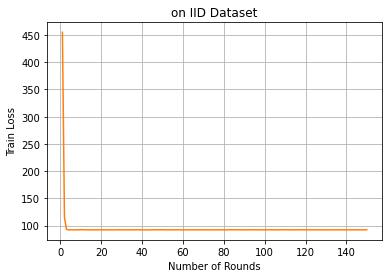

In [28]:
if torch.cuda.is_available():
  model_iid.cuda()

model_iid_trained = training(model_iid, rounds, batch_size, num_classes, lr, dataset_train, iid_dict, C, K, E, "on IID Dataset", "orange", True)

## Testing

In [29]:
criterion = nn.MSELoss()
testing(model_iid_trained, dataset_test, K, criterion, num_classes, classes_test, False)


Test Loss: 74.834360



# Non IID training

## Training

In [30]:
# number of training rounds
rounds = 200
# client fraction
C = 1
# number of clients
K = 10
# number of training passes on local dataset for each round
E = 10
# batch size
batch_size = 10
# learning Rate
lr=0.01
# data partition dictionary
client_dict = non_iid_partition(dataset_train, clients=K, total_shards=K, shards_size=40, num_shards_per_client=1, report_iid_metric=True) # every client is given only one shard, which is very non_iid 
add_gaussian_noise(dataset_train, client_dict, 0, 0, 10)
non_iid_dict = client_dict_train_val_split(client_dict_in=client_dict, validation_ratio=0.2)


# loader =  DataLoader(CustomDataset(dataset_train, client_dict[0]), batch_size=len( client_dict[0]), shuffle=True)
# ld = iter(loader).next()
# data, label = ld
# print("data: ", data, "label: ", label)
# load model
model_non_iid = IRIS_NN(input_size, num_hidden_neuron, output_size)


Variance of mean client data:  75.92971736252267
Note: a small value is expected for i.i.d partition.


----------------------------Round Summary--------------------------------
---> Round: 1, Average training loss: 6005.303024548687
---> Active Clients: [0 1 4 9 6 2 7 3 5 8]
---> Client Training Set Sizes: [32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
---> Validation losses: [14.677138328552246, 5.973413467407227, 140318.796875, 28.3759765625, 182.16339111328125, 41.33945846557617, 5.948613166809082, 30.254831314086914, 59.870243072509766, 15.418932914733887]
---> Weights of Local Models: [1.16829135e-01 2.87058209e-01 1.22201544e-05 6.04284884e-02
 9.41307339e-03 4.14789509e-02 2.88254980e-01 5.66758199e-02
 2.86405613e-02 1.11208563e-01]
-------------------------------------------------------------------------
----------------------------Round Summary--------------------------------
---> Round: 2, Average training loss: 73.95732252955438
---> Active Clients: [3 9 0 8 6 7 2 5 1 4]
---> Client Training Set Sizes: [32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
---> Validation losses: [3.04289674758

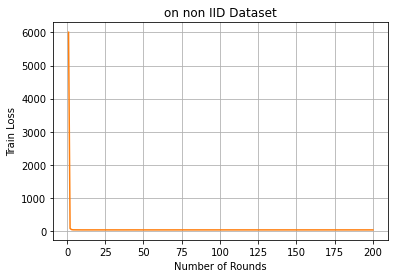

In [31]:
if torch.cuda.is_available():
  model_non_iid.cuda()

model_non_iid_trained = training(model_non_iid, rounds, batch_size, num_classes,lr, dataset_train, non_iid_dict, C, K, E, "on non IID Dataset", "orange", False)

## Test

In [33]:
criterion = nn.MSELoss()
testing(model_non_iid_trained, dataset_test, 10, criterion, num_classes, classes_test, False)

Test Loss: 74.029642

